# Value-based RL

拓展部分

个人兴趣的一些探索

## 1 env & utils

In [10]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
env = gym.make('CartPole-v0')
env = env.unwrapped
A_DIM = env.action_space.n
S_DIM = env.observation_space.shape[0]
print(' State Dimensions : ', S_DIM)
print(' Action Dimensions : ', A_DIM)

 State Dimensions :  4
 Action Dimensions :  2


In [12]:
EPOCHS = 500
capacity = 2048
mini_batch = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
def move_avg(a,n=100,mode="valid"):	# 滑动平均
    return(np.convolve(a, np.ones((n,))/n, mode=mode))	
    
def plot_G(model_name, rew): 
    plt.figure(figsize=[15, 6])
    
    plt.subplot(1,2,1)
    X = np.linspace(1,len(rew),len(rew))
    plt.plot(X, rew)
    plt.xlabel('epochs')
    plt.title(model_name)

    plt.subplot(1,2,2)
    rew = move_avg(rew, 100)
    X = np.linspace(1,len(rew),len(rew))
    plt.plot(X, rew)
    plt.xlabel('epochs')
    plt.title(model_name+'(avg)')
    plt.show()

In [14]:
def train(agent, epochs = EPOCHS):
    rew = list()
    print('\nagent learning...\n')
    for epoch in range(epochs):
        obs = env.reset()
        done = False
        final_reward = 0
        
        while not done:
            
            # env.render()
            loss = 0
            action = agent.choose_action(obs, epoch)
            obs_next, _, done, info = env.step(action)
            x, x_dot, theta, theta_dot = obs_next

            r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
            r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
            reward = r1 + r2
            
            agent.buffer.add(obs, action, reward, obs_next)
            final_reward += reward
            
            if agent.buffer.counter > capacity:
                loss = agent.learn()
                if done:
                    print('Ep: ', epoch,' | reward:%.3f'%final_reward, ' | loss:%.4f'%loss)

            obs = obs_next
            
        rew.append(final_reward)
    return rew

## 2 DQN
### 2.1 DQN
对于obs特征维度较高的任务（图像），单靠动态规划数组保存Q值不论是更新速度还是内存占用都不理想。因此引入深度模型。

In [15]:
%run DQN.py

In [16]:
from DQN import Replay_buffer, DQN

replay_buffer = Replay_buffer(capacity)
dqn = DQN(n_states=S_DIM,n_actions=A_DIM, replayer_buffer=replay_buffer, mini_batch=mini_batch, device = device)


agent learning...

Ep:  142  | reward:1.631  | loss:0.2974
Ep:  143  | reward:1.399  | loss:0.1729
Ep:  144  | reward:3.457  | loss:0.0841
Ep:  145  | reward:2.208  | loss:0.0488
Ep:  146  | reward:2.828  | loss:0.0435
Ep:  147  | reward:3.252  | loss:0.0508
Ep:  148  | reward:2.778  | loss:0.0606
Ep:  149  | reward:2.183  | loss:0.0458
Ep:  150  | reward:1.796  | loss:0.0586
Ep:  151  | reward:1.300  | loss:0.0420
Ep:  152  | reward:6.662  | loss:0.0398
Ep:  153  | reward:2.722  | loss:0.0260
Ep:  154  | reward:2.842  | loss:0.0257
Ep:  155  | reward:3.245  | loss:0.0307
Ep:  156  | reward:2.932  | loss:0.0270
Ep:  157  | reward:4.004  | loss:0.0177
Ep:  158  | reward:3.543  | loss:0.0288
Ep:  159  | reward:3.688  | loss:0.0193
Ep:  160  | reward:1.360  | loss:0.1386
Ep:  161  | reward:2.398  | loss:0.0520
Ep:  162  | reward:3.787  | loss:0.0337
Ep:  163  | reward:1.258  | loss:0.0281
Ep:  164  | reward:10.079  | loss:0.0210
Ep:  165  | reward:3.022  | loss:0.0211
Ep:  166  | reward:

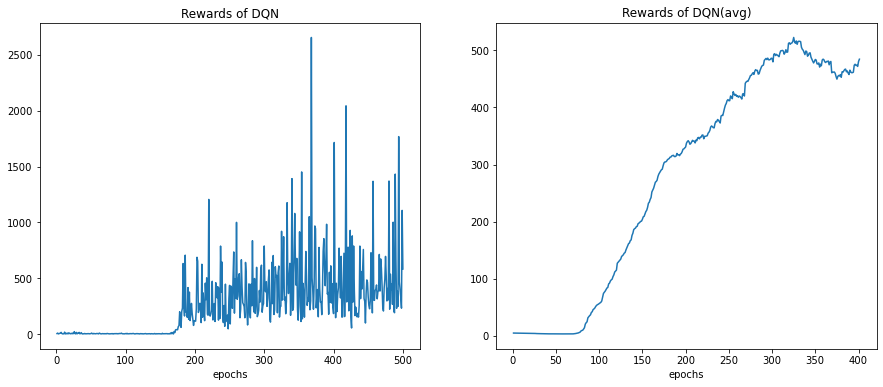

In [17]:
rew_dqn = train(dqn)

plot_G('Rewards of DQN', rew_dqn)

### 2.2 Double DQN
在Q-learning与DQN中，如下式子，对于动作的选择与评估使用了相同的value值。这会导致使得大概率选择过估计的value，进而对value的过于乐观的估计。
$$
{Q_*=R_{t+1}+\gamma max_a(Q(S_{t+1}, a_t; \theta_t))}
$$

个人理解是DQN使用动作的value的最大值选择动作与评估动作。由于更新策略使用的$Q(s^`, a^`)$是随机变量，并不稳定，但执行环境交互时却总是选择最高的值，使得模型过于“看重”动作的value，并想尽可能的提升value，使得动作的value被高估。类似于急于求成而自大的学者。

double DQN对于DQN的改动如下：
$$
{Q_*=R_{t+1}+\gamma Q^`(S_{t+1},argmax_a Q(S_{t+1}, a_t, \theta_t); \theta^`_t))}
$$


模型较DQN复杂，反向传播时需要综合考虑策略的value，导致学习简单离散动作较慢。


In [18]:
from DoubleDQN import Replay_buffer, Double_DQN

replay_buffer = Replay_buffer(capacity)
ddqn = Double_DQN(n_states=S_DIM, n_actions=A_DIM, replayer_buffer=replay_buffer, mini_batch=mini_batch, device = device)


agent learning...

Ep:  106  | reward:10.876  | loss:0.1121
Ep:  107  | reward:3.674  | loss:0.1136
Ep:  108  | reward:2.111  | loss:0.0836
Ep:  109  | reward:4.872  | loss:0.0723
Ep:  110  | reward:10.674  | loss:0.1233
Ep:  111  | reward:0.740  | loss:0.0674
Ep:  112  | reward:4.018  | loss:0.0770
Ep:  113  | reward:4.569  | loss:0.0446
Ep:  114  | reward:3.784  | loss:0.0535
Ep:  115  | reward:1.570  | loss:0.0322
Ep:  116  | reward:2.779  | loss:0.0221
Ep:  117  | reward:3.773  | loss:0.0175
Ep:  118  | reward:1.829  | loss:0.0144
Ep:  119  | reward:2.218  | loss:0.0623
Ep:  120  | reward:2.593  | loss:0.0363
Ep:  121  | reward:2.059  | loss:0.0348
Ep:  122  | reward:1.547  | loss:0.0181
Ep:  123  | reward:5.478  | loss:0.0153
Ep:  124  | reward:9.390  | loss:0.0081
Ep:  125  | reward:13.046  | loss:0.0157
Ep:  126  | reward:12.904  | loss:0.0102
Ep:  127  | reward:11.356  | loss:0.0305
Ep:  128  | reward:19.861  | loss:0.0094
Ep:  129  | reward:3.716  | loss:0.0086
Ep:  130  | re

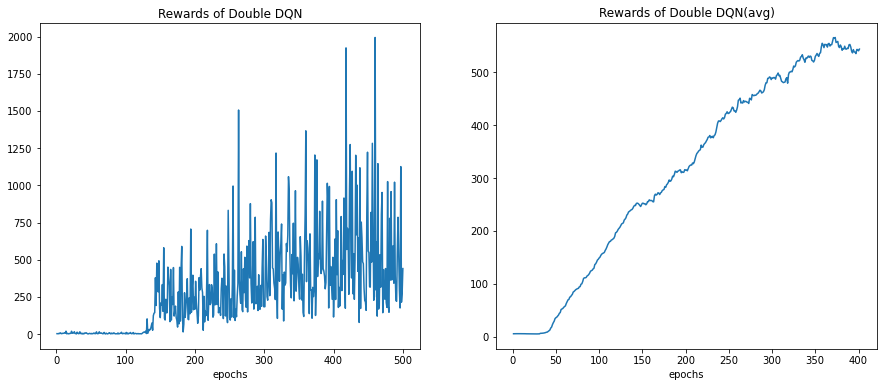

In [19]:
rew_ddqn = train(ddqn)
plot_G('Rewards of Double DQN', rew_ddqn)

### 2.3 Prioritized Experience Replay

顾名思义，就是将原来DQN随机采样的采样过程，替换成选择优先级更高的经验学习的过程，可以有效提高训练效率。

In [20]:
%run DQNPER.py

<Figure size 432x288 with 0 Axes>

In [21]:
from DQNPER import Priority_Replay_buffer, PERDQN

replay_buffer = Priority_Replay_buffer(capacity, S_DIM)
perdqn = PERDQN(S_DIM ,A_DIM, replayer_buffer=replay_buffer,mini_batch=mini_batch, device=device)


agent learning...

Ep:  75  | reward:10.434  | loss:0.0677
Ep:  76  | reward:3.764  | loss:0.0519
Ep:  77  | reward:1.208  | loss:0.0823
Ep:  78  | reward:4.609  | loss:0.0456
Ep:  79  | reward:7.549  | loss:0.0388
Ep:  80  | reward:2.864  | loss:0.0284
Ep:  81  | reward:2.763  | loss:0.0288
Ep:  82  | reward:2.171  | loss:0.0273
Ep:  83  | reward:3.092  | loss:0.0760
Ep:  84  | reward:3.121  | loss:0.0577
Ep:  85  | reward:5.893  | loss:0.0142
Ep:  86  | reward:4.456  | loss:0.0117
Ep:  87  | reward:5.651  | loss:0.0103
Ep:  88  | reward:6.453  | loss:0.0715
Ep:  89  | reward:11.535  | loss:0.0077
Ep:  90  | reward:4.201  | loss:0.0050
Ep:  91  | reward:3.580  | loss:0.0049
Ep:  92  | reward:22.783  | loss:0.0064
Ep:  93  | reward:14.236  | loss:0.0199
Ep:  94  | reward:76.272  | loss:0.0056
Ep:  95  | reward:26.467  | loss:0.0122
Ep:  96  | reward:30.268  | loss:0.0067
Ep:  97  | reward:57.058  | loss:0.0110
Ep:  98  | reward:47.754  | loss:0.0161
Ep:  99  | reward:60.735  | loss:0.

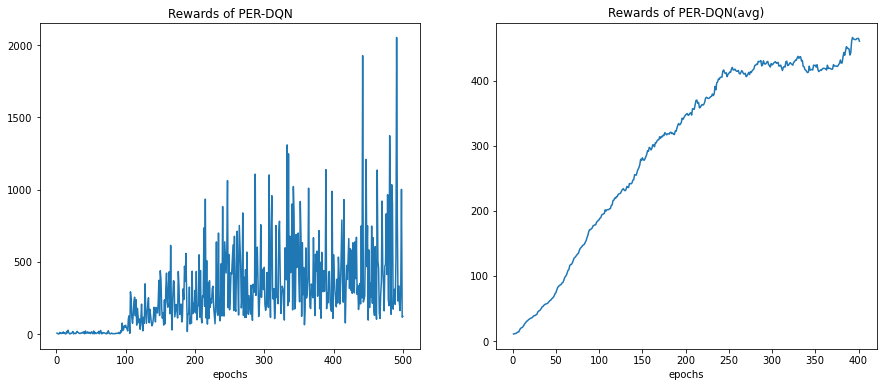

In [22]:
rew_perdqn = train(perdqn)

plot_G('Rewards of PER-DQN', rew_perdqn)

## Dueling DQN

相较于其他DQN的变体，DuelingDQN没有数学上的创新，而是在网络结构上将单纯的Q值输出分成两个部分
- 优势函数A
- 值函数V
$$
Q(s,a;\theta,\alpha,\beta)=V(s;\theta,\beta)+A(s,a;\theta,\alpha)
$$

为了解决上述公式存在的“unidentifiable”的问题（比如V和A分别加上和减去一个值能够得到同样的Q，但反过来显然无法由Q得到唯一的V和A），作者强制优势函数估计量在选定的动作处具有零优势。，也就是说让网络的最后一个模块实现前向映射。

$$
Q(s,a;\theta,\alpha,\beta)=V(s;\theta,\beta)+(A(s,a;\theta,\alpha)- max_{a^`\in |A|}A(s, a^`;\theta, \alpha))
$$

In [23]:
%run DuelingDQN.py

<Figure size 432x288 with 0 Axes>

In [24]:
from DuelingDQN import DuelingDQN

replay_buffer = Priority_Replay_buffer(capacity, S_DIM)

duelingdqn = DuelingDQN(S_DIM, A_DIM, replayer_buffer=replay_buffer, mini_batch=mini_batch)


agent learning...

Ep:  159  | reward:2.996  | loss:0.1025
Ep:  160  | reward:3.917  | loss:0.0470
Ep:  161  | reward:2.240  | loss:0.0336
Ep:  162  | reward:5.773  | loss:0.0337
Ep:  163  | reward:4.404  | loss:0.0252
Ep:  164  | reward:1.669  | loss:0.0259
Ep:  165  | reward:3.897  | loss:0.0212
Ep:  166  | reward:3.112  | loss:0.0203
Ep:  167  | reward:2.928  | loss:0.0922
Ep:  168  | reward:4.517  | loss:0.0348
Ep:  169  | reward:2.504  | loss:0.0207
Ep:  170  | reward:3.460  | loss:0.0167
Ep:  171  | reward:2.725  | loss:0.0156
Ep:  172  | reward:2.075  | loss:0.0137
Ep:  173  | reward:3.144  | loss:0.0102
Ep:  174  | reward:2.914  | loss:0.0097
Ep:  175  | reward:4.558  | loss:0.0076
Ep:  176  | reward:2.803  | loss:0.0408
Ep:  177  | reward:10.127  | loss:0.0116
Ep:  178  | reward:9.823  | loss:0.0091
Ep:  179  | reward:37.051  | loss:0.0176
Ep:  180  | reward:9.930  | loss:0.0064
Ep:  181  | reward:71.279  | loss:0.0062
Ep:  182  | reward:31.950  | loss:0.0050
Ep:  183  | rewa

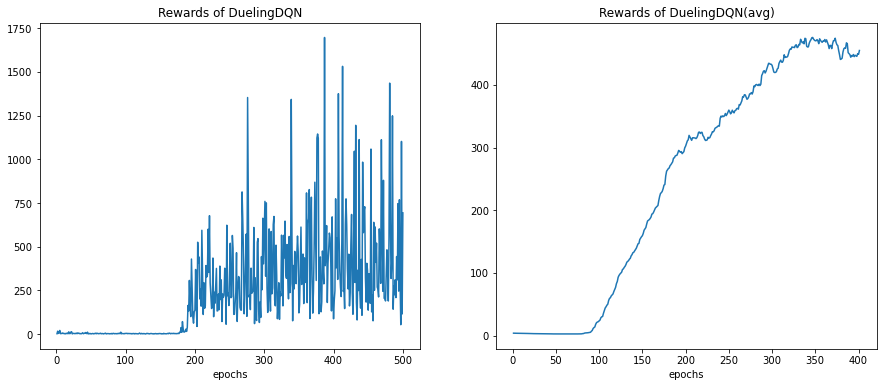

In [25]:
rew_duelingdqn = train(duelingdqn)

plot_G('Rewards of DuelingDQN', rew_duelingdqn)

C:\Users\avanz\anaconda3\envs\rl\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\avanz\anaconda3\envs\rl\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\avanz\anaconda3\envs\rl\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\avanz\anaconda3\envs\rl\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `linepl

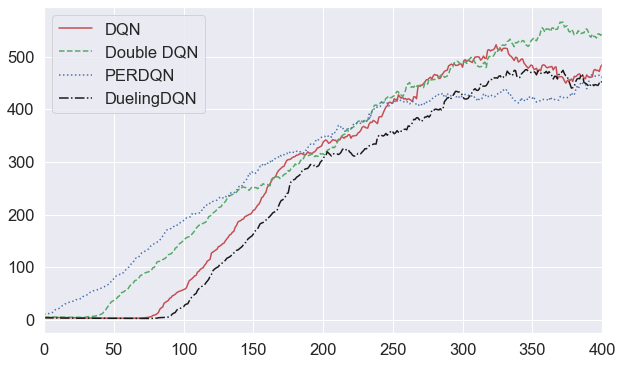

In [29]:
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.5)
fig = plt.figure(figsize=[10, 6])
xdata = np.linspace(0, 500, 500)
linestyle = ['-', '--', ':', '-.']
color = ['r', 'g', 'b', 'k']
label = ['DQN', 'Double DQN', 'PERDQN', 'DuelingDQN']

rew = [move_avg(rew_dqn), move_avg(rew_ddqn), move_avg(rew_perdqn), move_avg(rew_duelingdqn)]
for i in range(4):   
    sns.tsplot(data=rew[i], color=color[i], linestyle=linestyle[i], condition=label[i])
